In [1]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch import nn
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
torch.manual_seed(17)

## Loading the MNIST dataset

In [2]:
mnist_dataset = datasets.MNIST(root='./data' , train='True', download='False', transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 181933875.86it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114494984.71it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 79501228.82it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 13735060.40it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



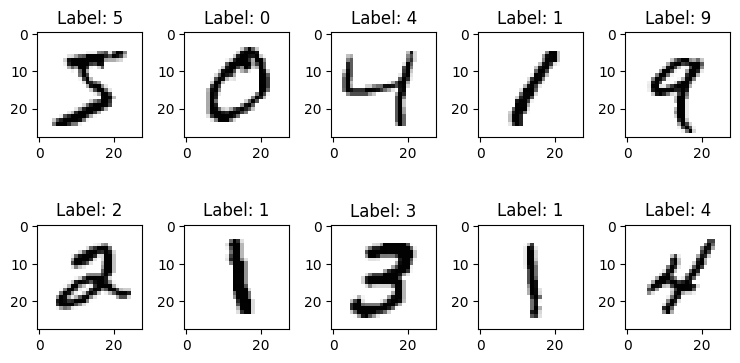

In [3]:
def plot_set_images(n_row, n_col, images, labels, label_text="Label: "):
  num=len(images)
  num_row=n_row
  num_col=n_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(images[i].reshape(28, 28), cmap='gray_r')
      ax.set_title('{}{}'.format(label_text, labels[i]))
  plt.tight_layout()
  plt.show()

images_set = []
labels_set = []
for i in range(10):
  images_set.append(mnist_dataset[i][0])
  labels_set.append(mnist_dataset[i][1])
plot_set_images(2, 5, images_set, labels_set, "Label: ")

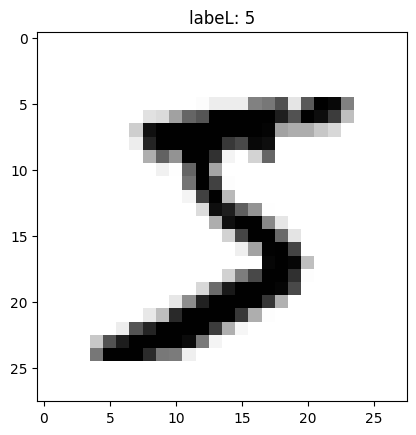

In [4]:
def plot_image(image, label):
  plt.imshow(image.reshape(28, 28), cmap="gray_r")
  plt.title("labeL: {}".format(label))

plot_image(mnist_dataset[0][0], mnist_dataset[0][1])

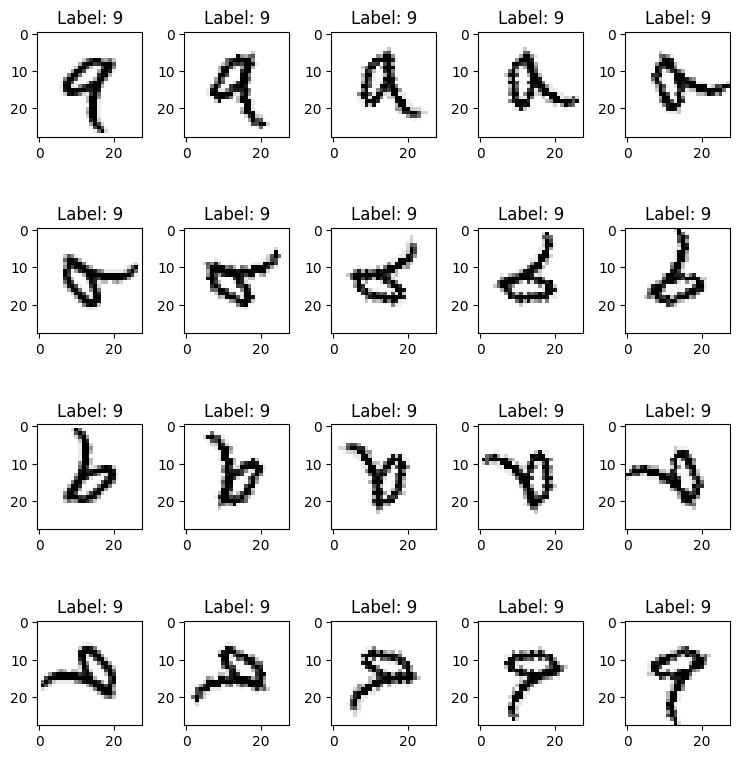

In [5]:
def rotation(x, angle):
  return TF.rotate(x, angle)

n = 20
image = mnist_dataset[4][0]
rotated_images=[]
labels = [mnist_dataset[4][1] for i in range(n)]
for i in range(n):
  r_image = rotation(image, 18*i)
  rotated_images.append(r_image)

plot_set_images(4, 5, rotated_images, labels)

In [6]:
!git clone https://github.com/gregversteeg/NPEET.git
!pip install NPEET/.

Cloning into 'NPEET'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 129 (delta 21), reused 35 (delta 19), pack-reused 87
Receiving objects: 100% (129/129), 317.14 KiB | 17.62 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Processing ./NPEET
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for NPEET: filename=NPEET-1.0.1-py3-none-any.whl size=7347 sha256=53e6fe84b2de4e60875085bd2e2877487cb9d5e881d7e334b02fa07bf6f33b3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ss1kgmxu/wheels/4a/18/bf/cc16ec442e14bcbcb4024a1a0b17a227bb48af92abddcef39e
Successfully built NPEET


In [7]:
from npeet import entropy_estimators as ee

def mutual_info_calculator(image1, image2):
  return ee.mi(image1, image2)



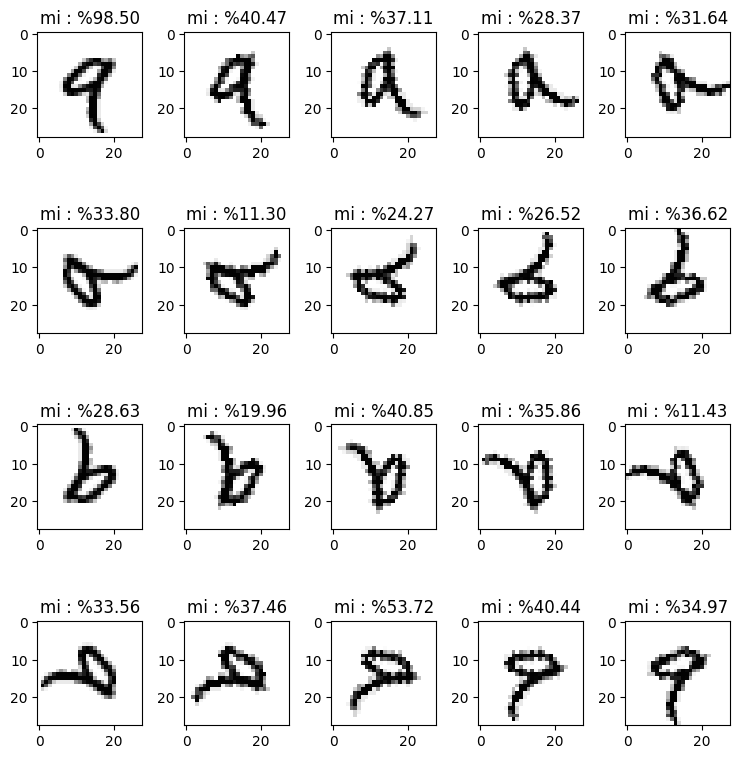

In [8]:
mutual_informations = []
clean_data_mi = mutual_info_calculator(rotated_images[0].numpy().reshape(28, 28).tolist(), rotated_images[0].numpy().reshape(28, 28).tolist())
# mutual_informations.append(clean_data_mi/clean_data_mi*100)
for i in range(0, len(rotated_images)):
  t_mi = mutual_info_calculator(rotated_images[0].numpy().reshape(28, 28).tolist(), rotated_images[i].numpy().reshape(28, 28).tolist())/clean_data_mi*100.
  if t_mi < 0:
    t_mi = 0

  elif t_mi > 100.0:
    t_mi = 100.0

  mutual_informations.append(t_mi)

mutual_info = ["{:.2f}".format(y) for y in mutual_informations]
plot_set_images(4, 5, rotated_images, mutual_info, "mi : %")

## Transform Policies

In [9]:
from torchvision import transforms

test_policy = transforms.Compose([
                # transforms.ToPILImage(),
                # transforms.RandomRotation(30),
                transforms.Pad(4),
                # transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(28),
                transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
            ])

In [10]:
from torchvision.transforms.autoaugment import AutoAugmentPolicy

torch.manual_seed(38)
auto_aug_policy = transforms.Compose([
                    transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
                    transforms.ToTensor(),
                    # transforms.Normalize(mean=[0.1306], std=[0.3081])
                ])

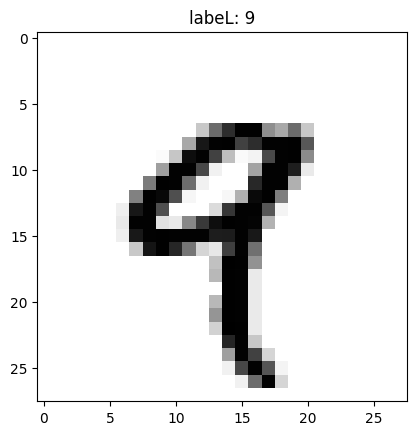

In [11]:
clean_image = mnist_dataset[4][0]
plot_image(image, 9)

## Calculating Average Ratio of Mutual Info. among Clean image and its Augmented ones

In [12]:
def policy_based_augmentation(clean_image, policy):
  n=20
  trans_t2PIL = transforms.ToPILImage()
  image = trans_t2PIL(clean_image)
  augmented_images = []
  augmented_images.append(clean_image)
  for i in range(1, n):
    augmented_images.append(policy(image))


  base = mutual_info_calculator(clean_image.numpy().reshape(28, 28).tolist(), clean_image.numpy().reshape(28, 28).tolist())
  mutual_info = []
  for i in range(n):
        t_mi = (mutual_info_calculator(augmented_images[0].numpy().reshape(28, 28).tolist(), augmented_images[i].numpy().reshape(28, 28).tolist())/base)*100.
        if t_mi < 0:
          t_mi = 0

        elif t_mi > 100.0:
          t_mi = 100.0

        mutual_info.append(t_mi)

  return mutual_info, augmented_images

### An Example :

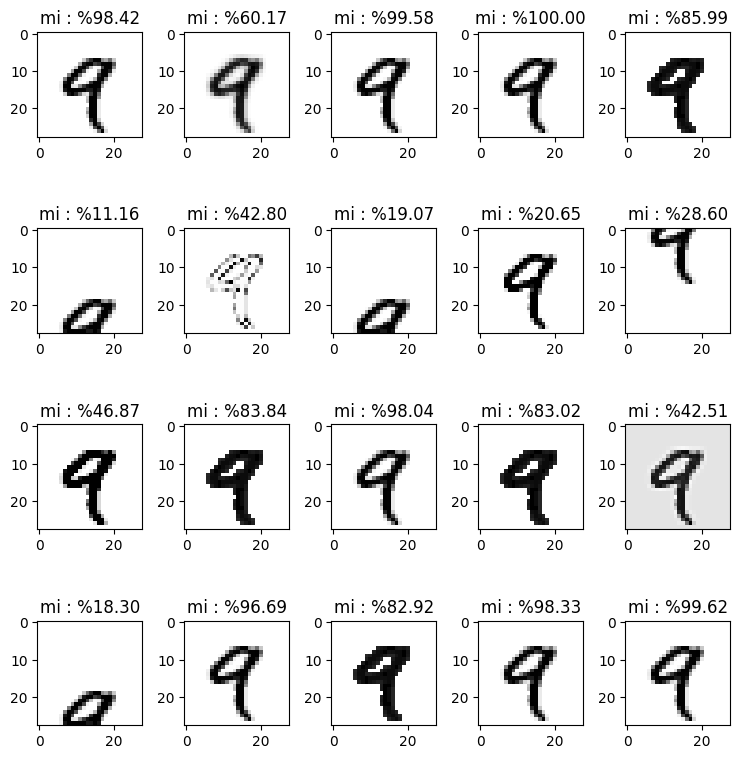

In [13]:
mi, ai = policy_based_augmentation(clean_image, auto_aug_policy)
mi = ["{:.2f}".format(y) for y in mi]
plot_set_images(4, 5, ai, mi, "mi : %")

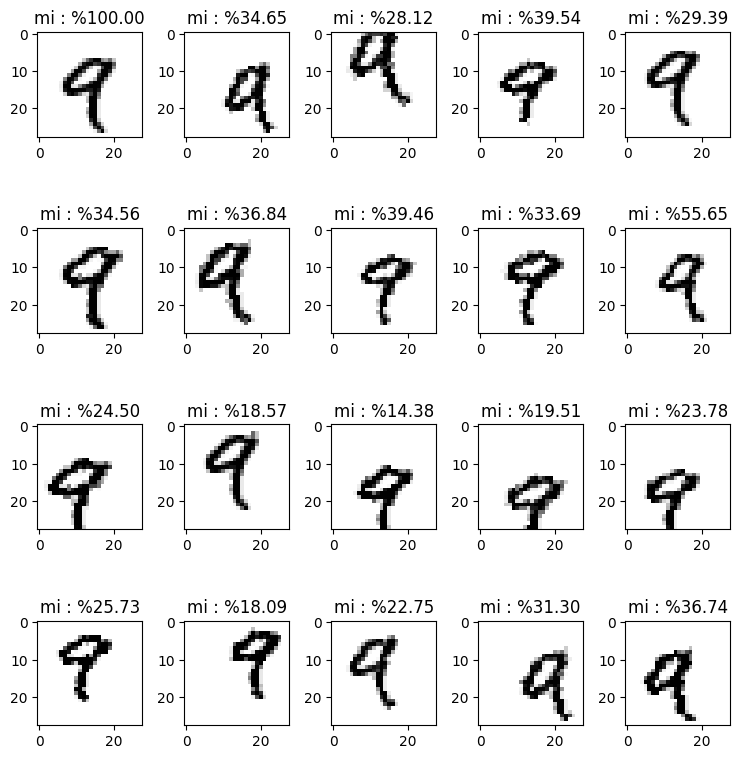

In [14]:
mi, ai = policy_based_augmentation(clean_image, test_policy)
mi = ["{:.2f}".format(y) for y in mi]
plot_set_images(4, 5, ai, mi, "mi : %")

In [15]:
def mi_over_dataset_policy_based_calculator(policy ):
  average_mutual_infos = np.zeros(len(mnist_dataset))
  aug_images = []
  rnd_mi = []
  j=0

  for i in tqdm(range(len(mnist_dataset))):
    clean_image = mnist_dataset[i][0]
    mi, ai = policy_based_augmentation(clean_image, policy)
    average_mi = np.mean(np.array(mi[:]))
    average_mutual_infos[i] = average_mi

    if(i == 6000*j):
      k =  random.randint(0, 100)

    if(i==6000*j+k):
      aug_images.append(ai)
      rnd_mi.append(mi)
      j += 1

  return aug_images, rnd_mi, average_mutual_infos


In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [16]:
aug_images, rnd_mi, average_mutual_infos = mi_over_dataset_policy_based_calculator(auto_aug_policy)

100%|██████████| 60000/60000 [30:24<00:00, 32.89it/s]


In [17]:
average_mutual_infos.tofile("average_mi_array")
average_mutual_infos = np.fromfile("average_mi_array")
overall_average_mi = np.mean(average_mutual_infos)
print(overall_average_mi)

72.93449762512756


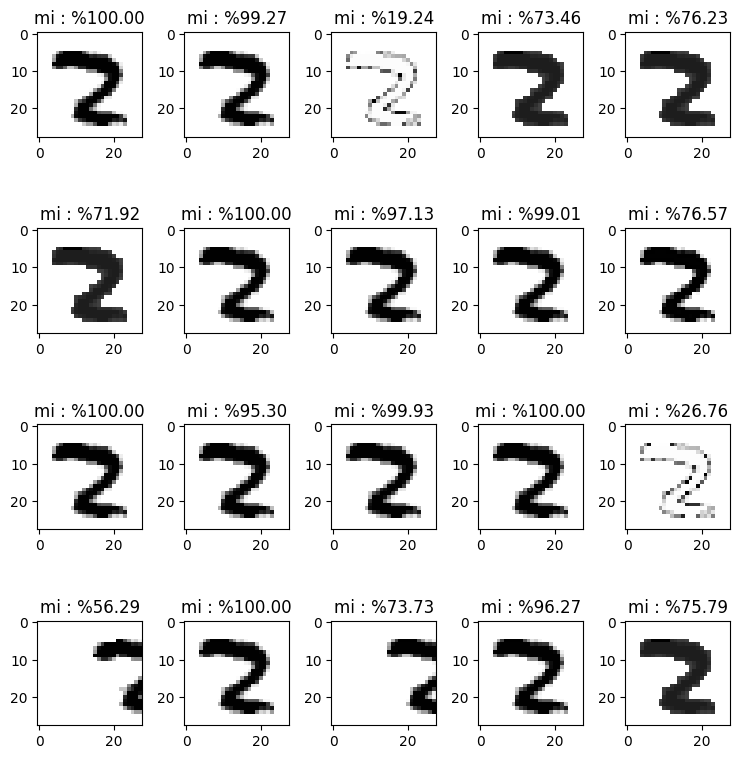


---------------------------------------------------------------------------------------------



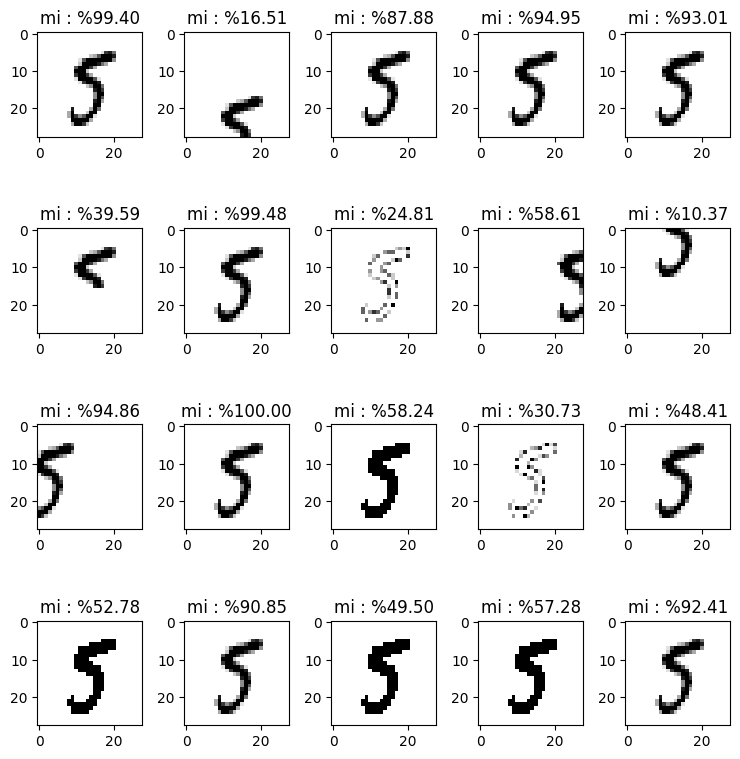


---------------------------------------------------------------------------------------------



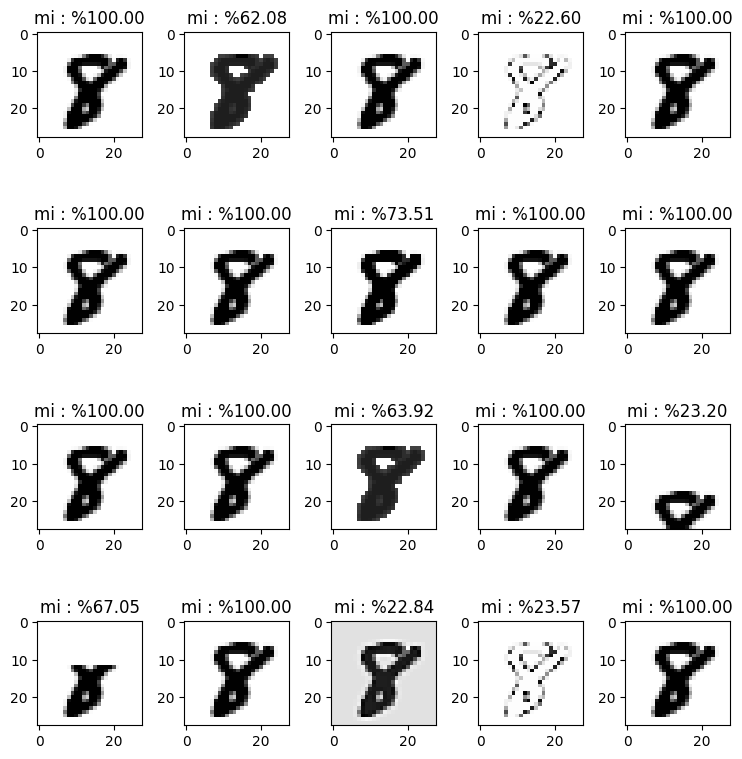


---------------------------------------------------------------------------------------------



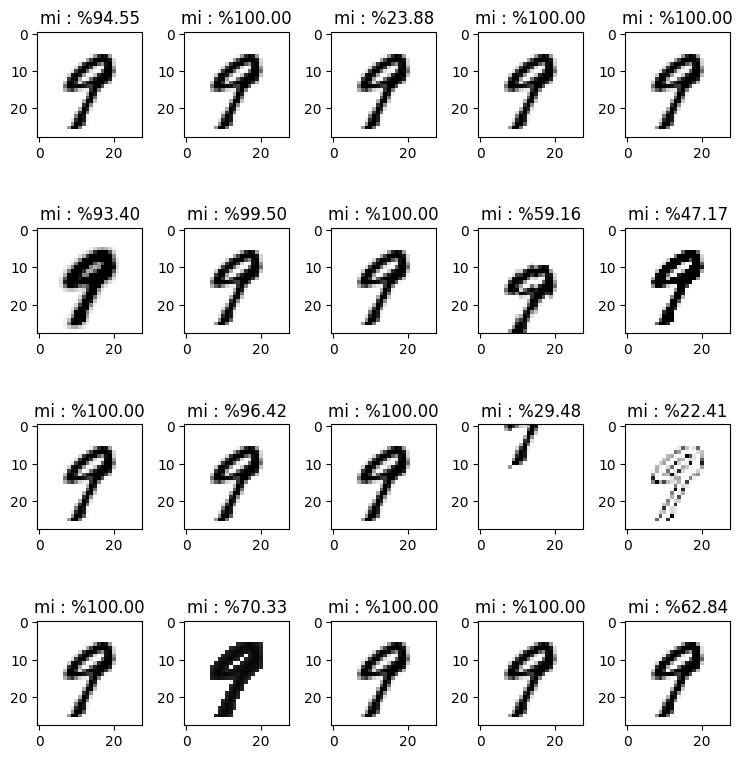


---------------------------------------------------------------------------------------------



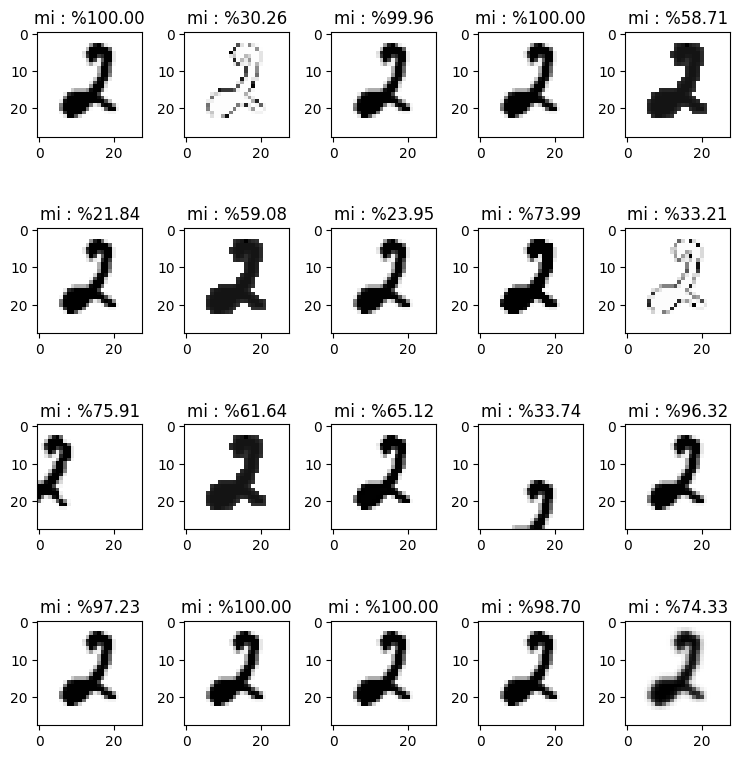


---------------------------------------------------------------------------------------------



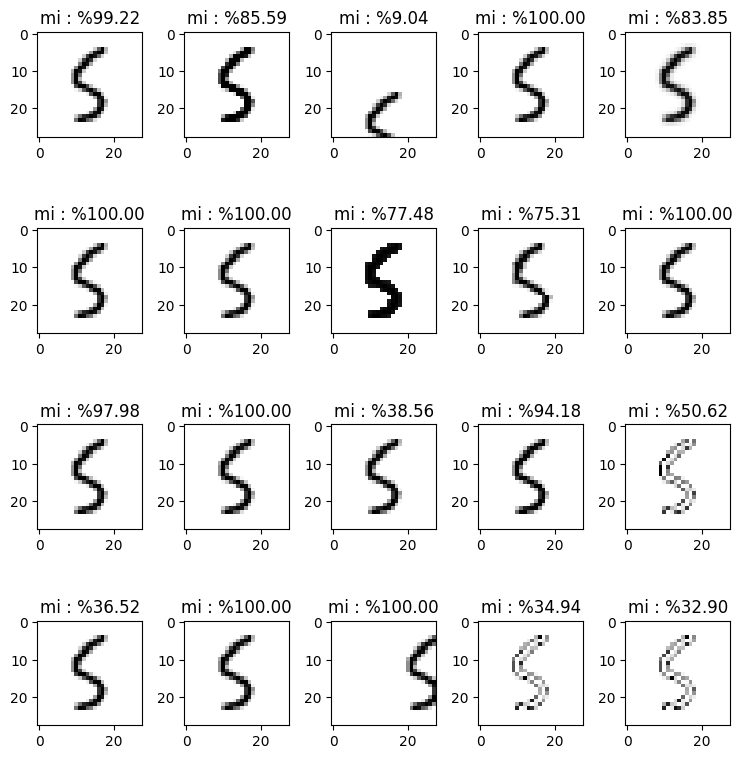


---------------------------------------------------------------------------------------------



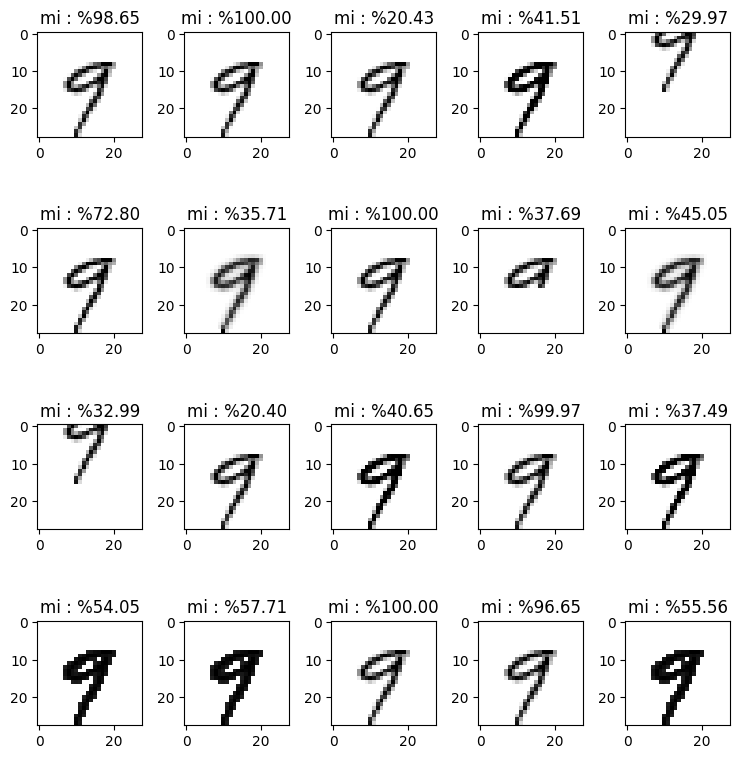


---------------------------------------------------------------------------------------------



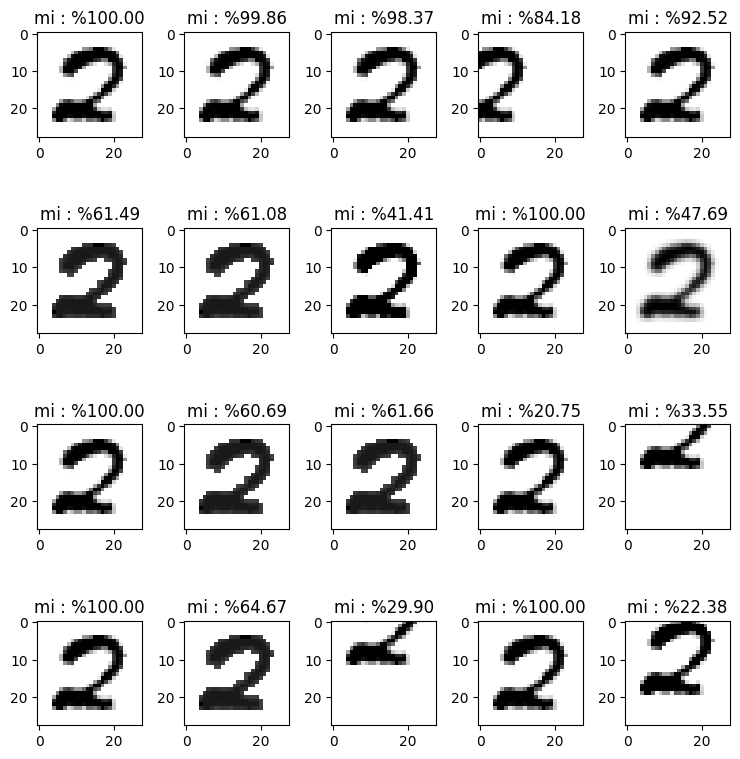


---------------------------------------------------------------------------------------------



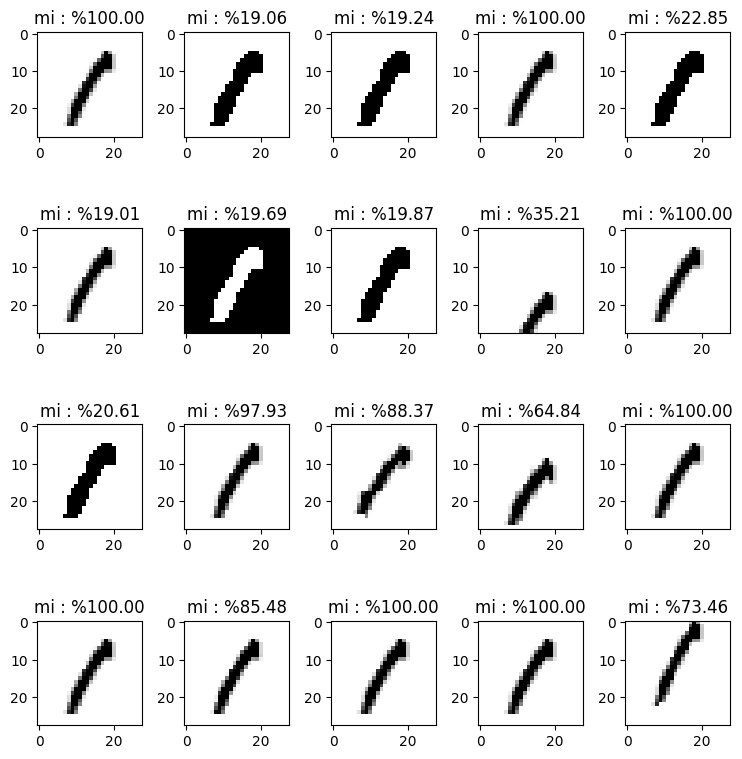


---------------------------------------------------------------------------------------------



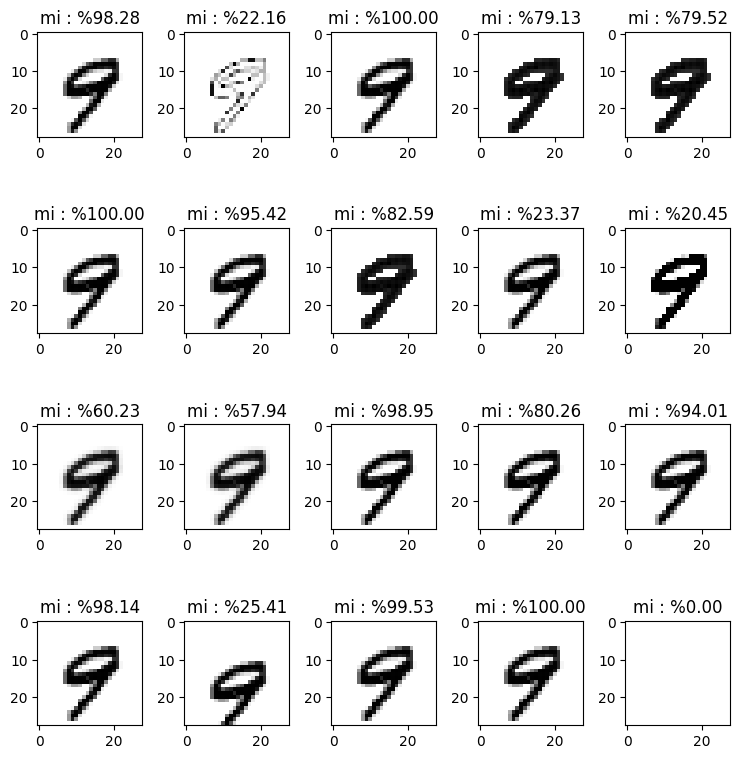


---------------------------------------------------------------------------------------------



In [18]:
for i in range(len(aug_images)):
  mi = ["{:.2f}".format(y) for y in rnd_mi[i]]
  plot_set_images(4, 5, aug_images[i], mi, "mi : %")
  print()
  print("---------------------------------------------------------------------------------------------")
  print()

In [ ]:
aug_images, rnd_mi, average_mutual_infos =  mi_over_dataset_policy_based_calculator(test_policy)

100%|██████████| 60000/60000 [41:20<00:00, 24.19it/s]


In [ ]:
average_mutual_infos.tofile("average_mi_array")
average_mutual_infos = np.fromfile("average_mi_array")
overall_average_mi = np.mean(average_mutual_infos)
print(overall_average_mi)

38.61472677052099


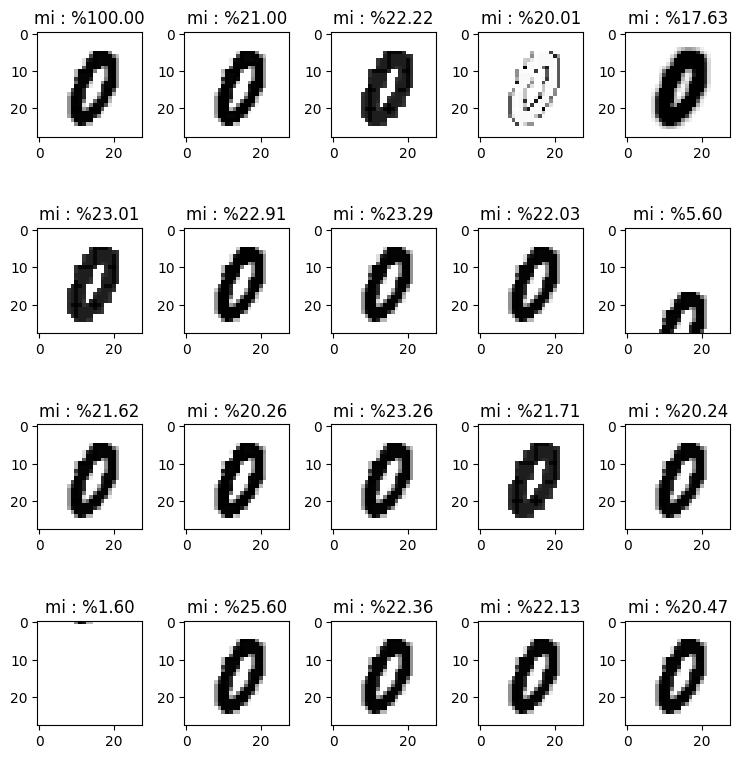


---------------------------------------------------------------------------------------------



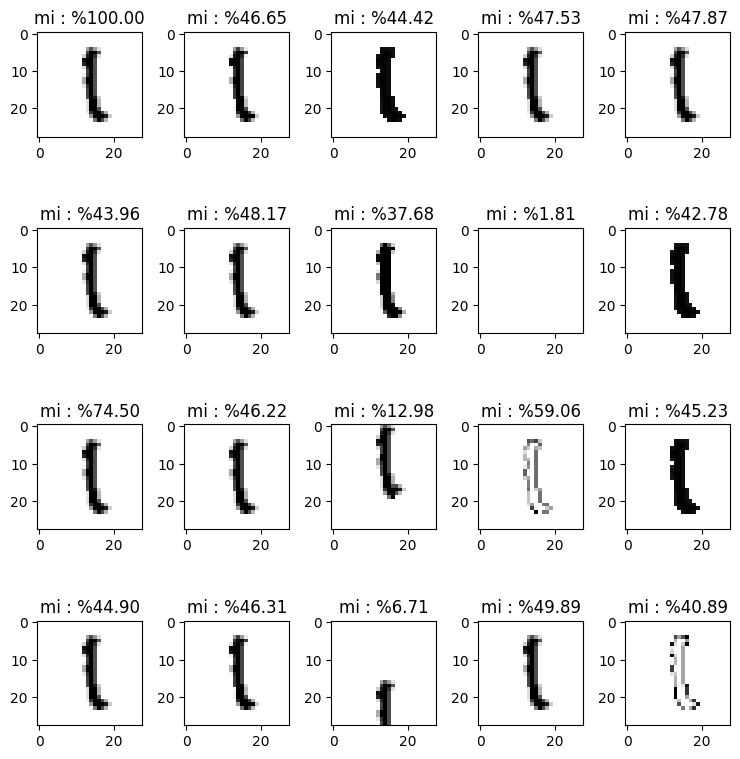


---------------------------------------------------------------------------------------------



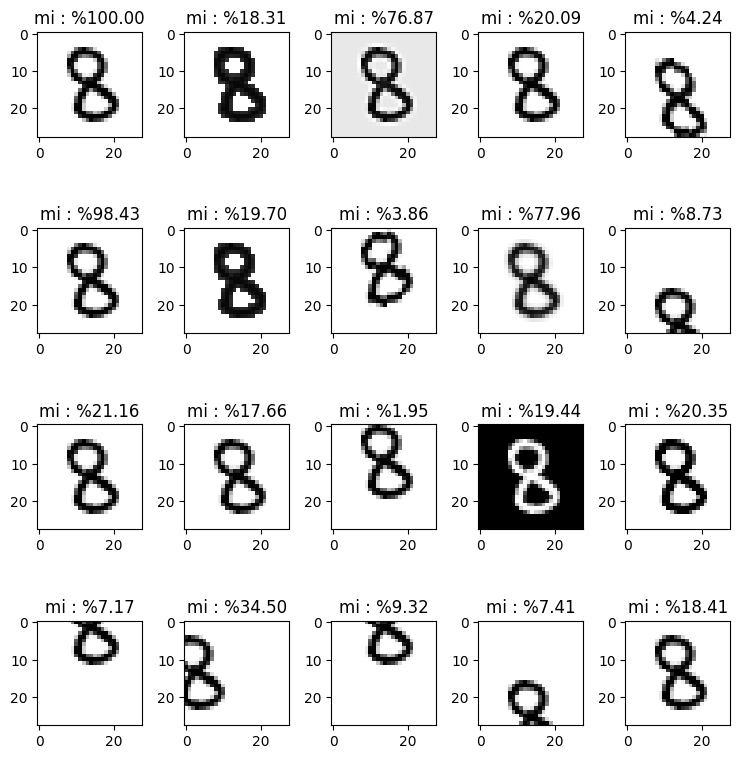


---------------------------------------------------------------------------------------------



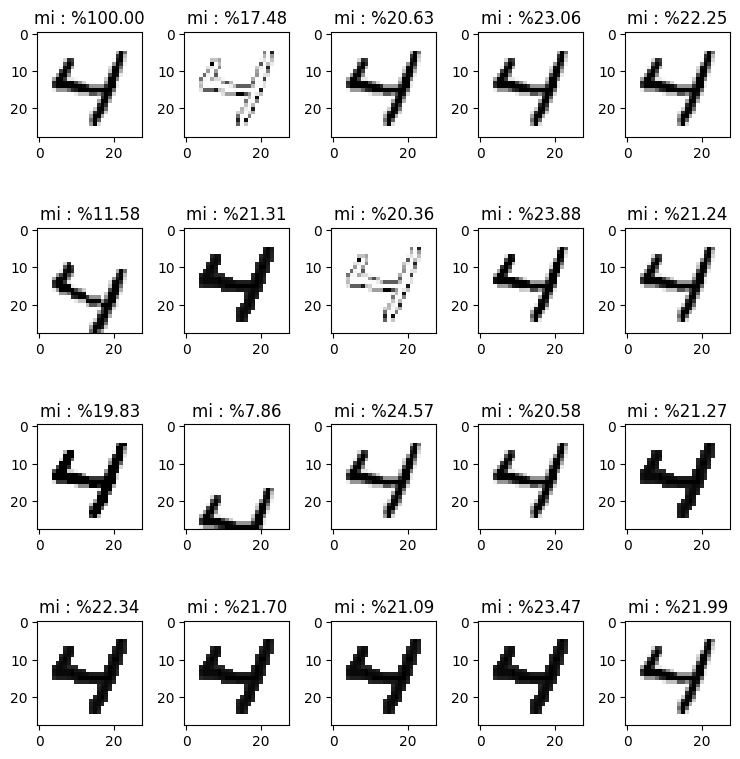


---------------------------------------------------------------------------------------------



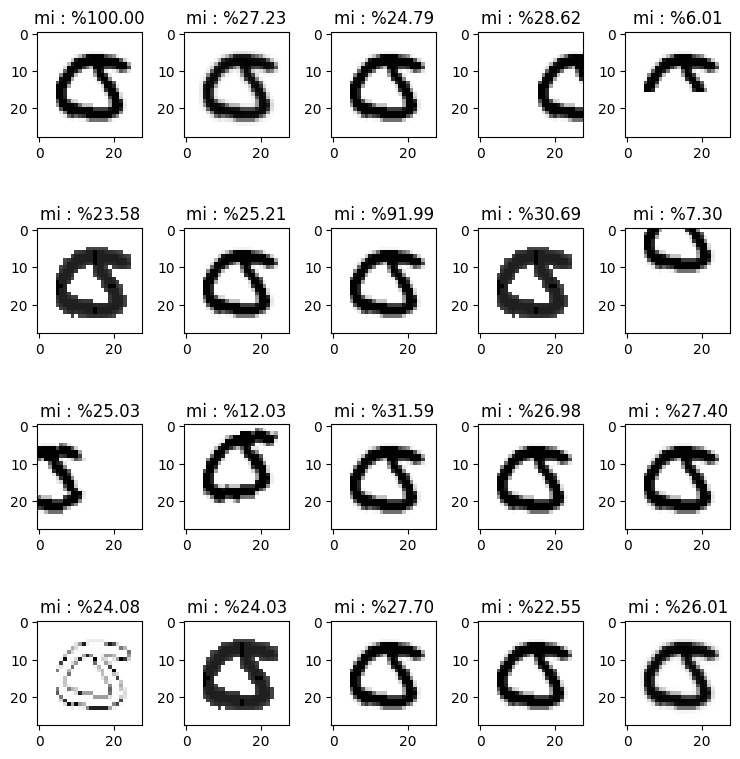


---------------------------------------------------------------------------------------------



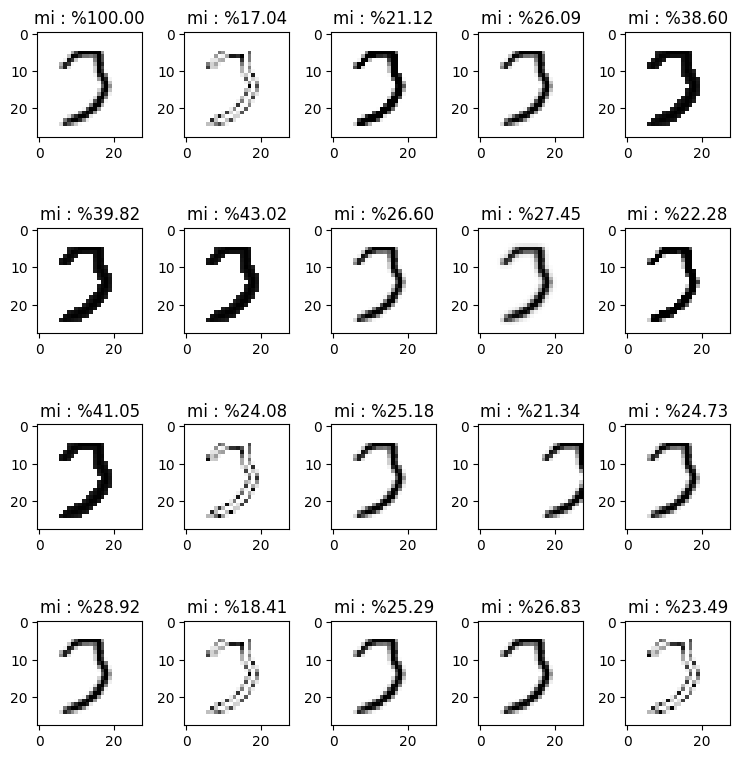


---------------------------------------------------------------------------------------------



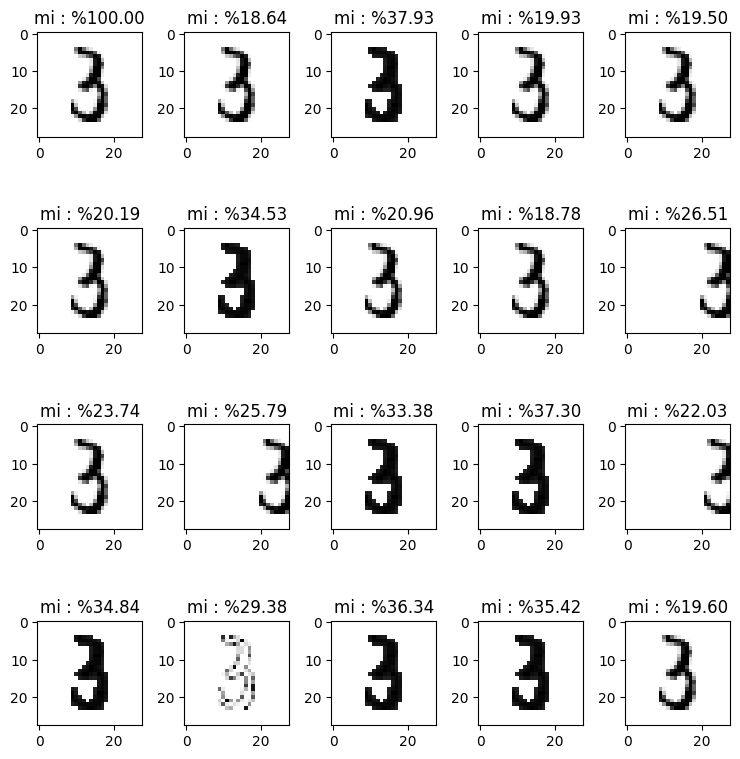


---------------------------------------------------------------------------------------------



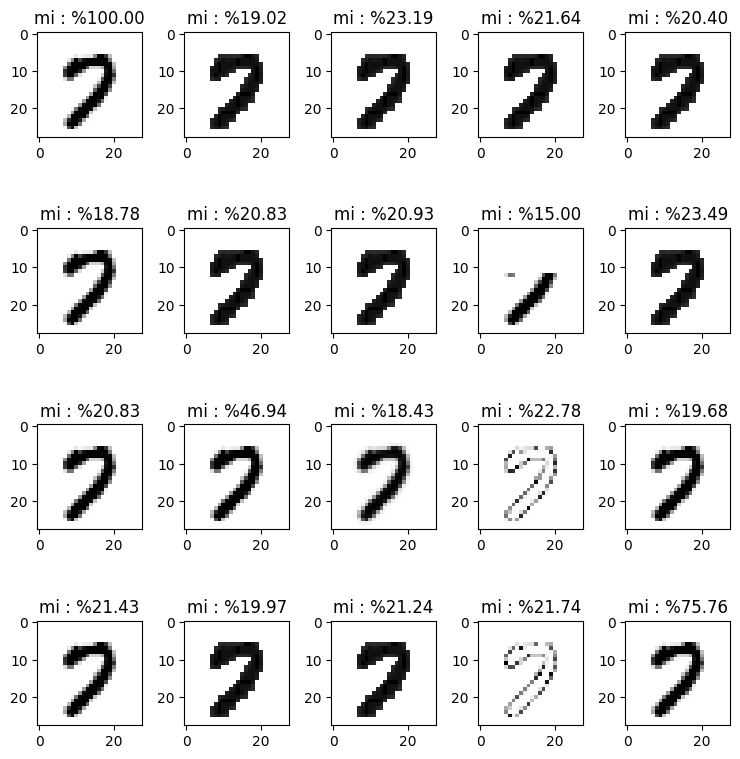


---------------------------------------------------------------------------------------------



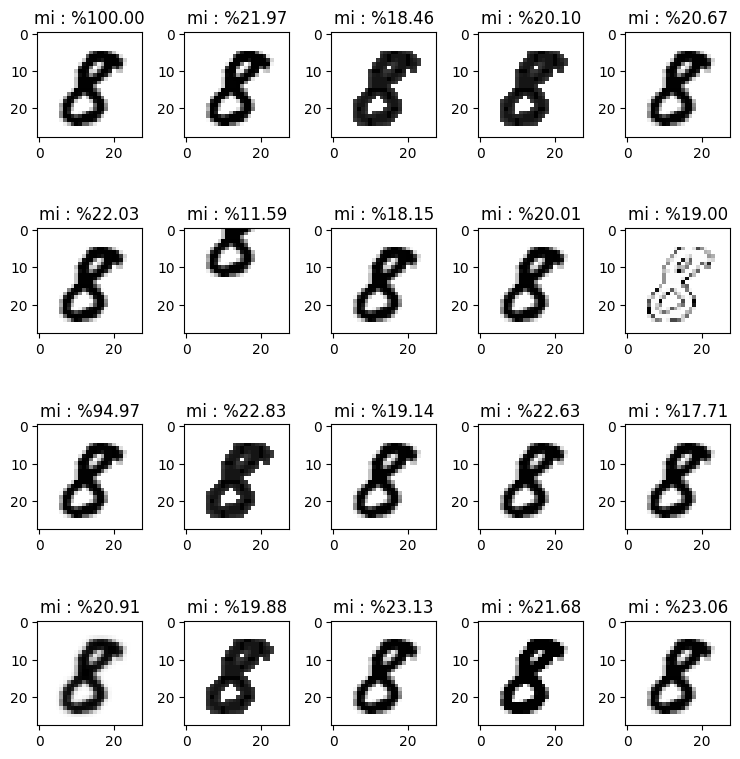


---------------------------------------------------------------------------------------------



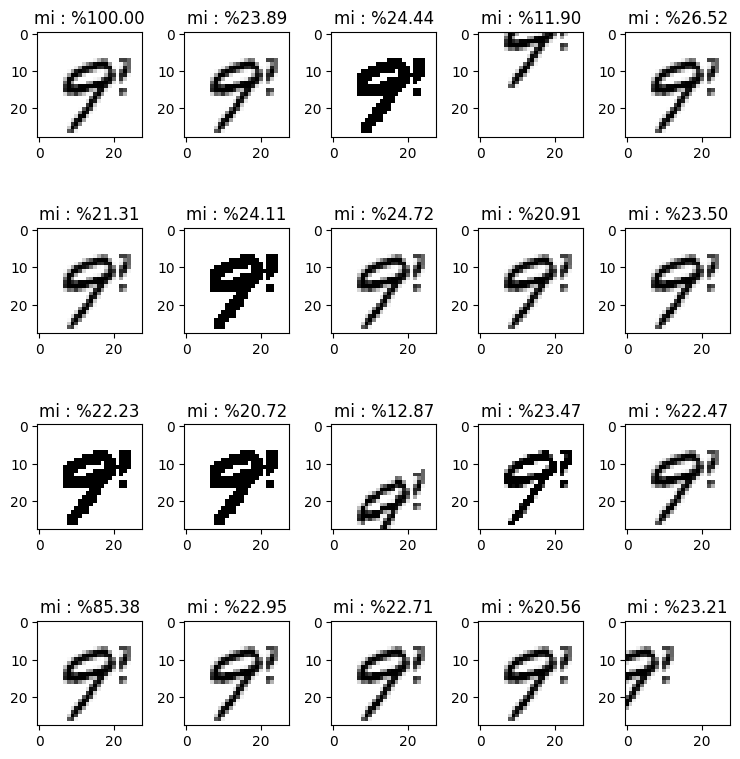


---------------------------------------------------------------------------------------------



In [ ]:
for i in range(len(aug_images)):
  mi = ["{:.2f}".format(y) for y in rnd_mi[i]]
  plot_set_images(4, 5, aug_images[i], mi, "mi : %")
  print()
  print("---------------------------------------------------------------------------------------------")
  print()